In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import time
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from keras.preprocessing.image import ImageDataGenerator, load_img

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/vietnamese_document_data.zip' -d '/document_data'

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /document_data/document_data/Kinh doanh/KD_NLD_ (3366).txt  
  inflating: /document_data/document_data/Kinh doanh/KD_TN_ (3187).txt  
  inflating: /document_data/document_data/Kinh doanh/KD_TN_ (3236).txt  
  inflating: /document_data/document_data/Kinh doanh/KD_TN_ (3279).txt  
  inflating: /document_data/document_data/Kinh doanh/KD_TN_ (3283).txt  
  inflating: /document_data/document_data/Kinh doanh/KD_TN_ (3298).txt  
  inflating: /document_data/document_data/Kinh doanh/KD_TN_ (3305).txt  
  inflating: /document_data/document_data/Kinh doanh/KD_NLD_ (3342).txt  
  inflating: /document_data/document_data/Kinh doanh/KD_NLD_ (3399).txt  
  inflating: /document_data/document_data/Kinh doanh/KD_NLD_ (3401).txt  
  inflating: /document_data/document_data/Kinh doanh/KD_NLD_(3314).txt  
  inflating: /document_data/document_data/Kinh doanh/KD_NLD_ (3336).txt  
  inflating: /document_data/document_data/Kinh doanh/KD_NLD_ (

In [ ]:
!/usr/bin/python3
# -*- coding: <encoding name> -*-

Python 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> exit()


**Data preprocessing**

In [ ]:
!pip install deplacy underthesea

     |████████████████████████████████| 7.6 MB 5.1 MB/s 
     |████████████████████████████████| 743 kB 45.4 MB/s 
     |████████████████████████████████| 235 kB 52.3 MB/s 
     |████████████████████████████████| 581 kB 53.1 MB/s 


In [ ]:
import regex as re
import chuanhoa
from underthesea import word_tokenize

def remove_html(txt):
    return re.sub(r'<[^>]*>', '', txt)
    
def text_preprocess(document):
    # Remove html code
    document = remove_html(document)
    # unicode
    document = chuanhoa.convert_unicode(document)
    # vietnamese
    document = chuanhoa.chuan_hoa_dau_cau_tieng_viet(document)
    # Separate word
    document = word_tokenize(document, format="text")
    # Upper to lower 
    document = document.lower()
    # Remove unnecessary characters
    document = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',document)
    # Remove space
    document = re.sub(r'\s+', ' ', document).strip()
    return document


In [ ]:
txt = 'Ngoài đường hiện có ít nhất 20% người không đeo khẩu trang'
print(text_preprocess(txt))

ngoài đường hiện có ít_nhất 20 người không đeo khẩu_trang


In [ ]:
# -*- coding: utf-8 -*-

file_name = '/document_data/document_data'

X, y = [], []
classes = ['Chinh tri Xa hoi', 
           'Doi song', 
           'Khoa hoc', 
           'Kinh doanh', 
           'Phap luat', 
           'Suc khoe', 
           'The gioi', 
           'The thao',
           'Van hoa',
           'Vi tinh']

for class_name in classes:
    url = os.path.join(file_name, class_name)
    # print(url)
    for _, _, files in os.walk(url):
        for text in files:
            with open(os.path.join(url, text), 'rb') as f:
                content = f.read().decode('utf-16')
                X.append(text_preprocess(content))
            y.append(class_name)

In [ ]:
df = pd.DataFrame({
    "text": X,
    "label": y
})

In [ ]:
df.head()

,text,label
0,quy_trình lột_xác của những chiếc xe hết đát 9...,Chinh tri Xa hoi
1,ra_mắt trung_tâm phụ_nữ và phát_triển kỷ_niệm ...,Chinh tri Xa hoi
2,khai_mạc chương_trình du_lịch về cội_nguồn năm...,Chinh tri Xa hoi
3,cơn mưa chiều 7 7 cây đổ đường ngập tại đường ...,Chinh tri Xa hoi
4,thưởng tết cao nhất gần 100 triệu đồng tiền_lư...,Chinh tri Xa hoi


**Train test split data**
1. Split dataset into 80% train set and 20% test set
2. Convert label to number using LabelEncoding

In [ ]:
X = df['text']
y = df['label']
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=8)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
print("Training set: ", len(X_train))
print("Validation set: ", len(X_test))

Training set:  27007
Validation set:  6752


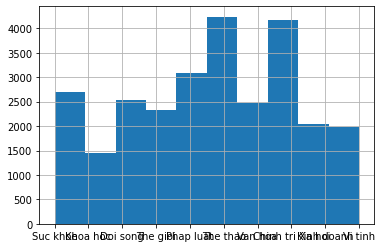

In [ ]:
y_train.hist()

In [ ]:
# Encode label
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print(list(label_encoder.classes_), '\n')

['Chinh tri Xa hoi', 'Doi song', 'Khoa hoc', 'Kinh doanh', 'Phap luat', 'Suc khoe', 'The gioi', 'The thao', 'Van hoa', 'Vi tinh'] 



In [ ]:
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
y_test

array([3, 0, 1, ..., 1, 7, 9])

**Classification**

Use support vector machine algorithm to learn model

In [ ]:
start_time = time.time()
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,1),
                                             max_df=0.8,
                                             max_features=None)), 
                     ('tfidf', TfidfTransformer()),
                     ('clf', SVC(gamma='scale'))
                    ])
text_clf = text_clf.fit(X_train, y_train)
 
train_time = time.time() - start_time
print('Done training SVM in', train_time, 'seconds.')

# Save model
MODEL_PATH = '/content/drive/MyDrive/'
pickle.dump(text_clf, open(os.path.join(MODEL_PATH, "svm.pkl"), 'wb'))

Done training SVM in 773.4471189975739 seconds.


**Evaluate model**

In [ ]:
model = pickle.load(open(os.path.join(MODEL_PATH,"svm.pkl"), 'rb'))
y_pred = model.predict(X_test)
print('SVM, Accuracy =', np.mean(y_pred == y_test))

SVM, Accuracy = 0.918542654028436


In [ ]:
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))

(0.9200028386625545, 0.9114554875500549, 0.9153277674731678, None)


In [ ]:
print(classification_report(y_test, y_pred, target_names=list(label_encoder.classes_)))

                  precision    recall  f1-score   support

Chinh tri Xa hoi       0.83      0.90      0.86      1044
        Doi song       0.86      0.86      0.86       632
        Khoa hoc       0.89      0.82      0.85       364
      Kinh doanh       0.90      0.90      0.90       510
       Phap luat       0.96      0.92      0.94       774
        Suc khoe       0.92      0.94      0.93       677
        The gioi       0.94      0.91      0.93       579
        The thao       0.99      0.98      0.99      1060
         Van hoa       0.94      0.94      0.94       616
         Vi tinh       0.96      0.95      0.95       496

        accuracy                           0.92      6752
       macro avg       0.92      0.91      0.92      6752
    weighted avg       0.92      0.92      0.92      6752

